In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show
from bokeh.resources import INLINE
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, Legend
from bokeh.models.tools import HoverTool
from bokeh.transform import factor_cmap, factor_mark


# Confgure bokeh to output into the notebook
output_notebook(INLINE)

Loading BokehJS ...

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from peco.peco_parsing import (
    import_peco_json,
    link_results_with_divisions,
    count_club_relative_placing,
    calculate_counter_pos,
    calculate_other_team_counters_beaten
)

In [3]:
# Specify the round for this notebook
peco_round = 5

In [4]:
# Set the path to the peco_all json
peco_path = 'peco/peco_all.json'.format(peco_round)

In [5]:
# Import the peco json to a dataframe
peco_raw_df = import_peco_json(peco_path)

# Get the data for the specified round
peco_raw_round_df = peco_raw_df[peco_raw_df['round'] == peco_round]

# Recalculate scoring position by excluding guest runners
peco_counter_df = calculate_counter_pos(peco_raw_round_df)

# Add in the club relative finishing positions
peco_club_scoring_df = count_club_relative_placing(peco_counter_df)

# Add in Division information
peco_division_df = link_results_with_divisions(peco_club_scoring_df)

# Calculate other team counters beaten
peco_division_df['counters_beaten'] = (
    peco_division_df.apply(lambda runner: calculate_other_team_counters_beaten(runner, peco_division_df), axis=1)
)

In [6]:
peco_analysis_df = peco_division_df

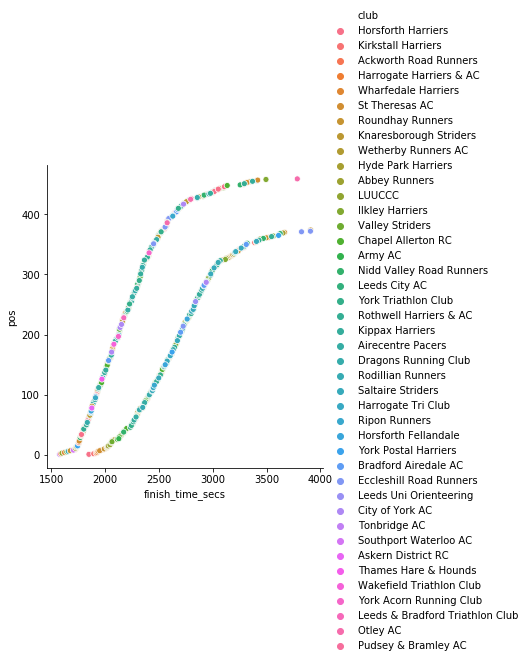

In [7]:
sns.relplot(data=peco_analysis_df, x='finish_time_secs', y='pos', hue='club')

In [8]:
# Convert the dataframe to a column data source for bokeh
peco_cds = ColumnDataSource(peco_analysis_df)

In [9]:
# Make some factors for divison and contest
division_factors = sorted(peco_analysis_df.division.unique().tolist())
contest_factors = sorted(peco_analysis_df.contest.unique().tolist())

# Make a colour map and a marker map
cmap = factor_cmap('division', palette=Category10[len(division_factors)], factors=division_factors)
markers = factor_mark('contest', ['asterisk', 'x'], factors=contest_factors)

In [10]:
# Plot runners by finishing position and time
p = figure(x_axis_type='datetime', height=450, width=900)
p.scatter(x='time', y='pos', color=cmap, size=6, marker=markers, source=peco_cds, legend='division')
p.title.text = 'Peco 2018-19 Round {} Results'.format(peco_round)
p.xaxis[0].formatter  = DatetimeTickFormatter(hourmin=['%H:%M:%S'])
p.xaxis.axis_label = 'Finish Time'
p.yaxis.axis_label = 'Finish Position'
hover = HoverTool()
hover.tooltips=[
    ('Name', '@name'),
    ('Club', '@club'),
    ('Overall Finish Position', '@pos (@time{%H:%M:%S})'),
    ('Category Position ', '@category_pos/@category_total (@category)')
]
hover.formatters={
    'time': 'datetime'
}

p.add_tools(hover)

show(p)

In [11]:
# Plot runners by finishing position and relative_counter_score
p = figure(height=450, width=900)
p.scatter(x='pos', y='counters_beaten', color=cmap, size=6, marker=markers, source=peco_cds, legend='division')
p.title.text = 'Peco 2018-19 Round {} Counters Beaten (within Division)'.format(peco_round)
p.yaxis.axis_label = 'Counters Beaten (within Division, excluding own team)'
p.xaxis.axis_label = 'Finish Position'

hover = HoverTool()
hover.tooltips=[
    ('Name', '@name'),
    ('Club', '@club (@contest @division)'),
    ('Overall Finish Position', '@pos (@time{%H:%M:%S})'),
    ('Category Position ', '@category_pos/@category_total (@category)'),
    ('Counters Beaten', '@counters_beaten')
]
hover.formatters={
    'time': 'datetime'
}

p.add_tools(hover)

show(p)

In [12]:
peco_analysis_df.to_csv('peco/peco_{}_analysis.csv'.format(peco_round), header=True, index=False)